In [1]:
# importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import f1_score

In [2]:
# reading the data
df = pd.read_csv("data/customer_data_engineered_features.csv")

In [3]:
df.head()

,Category,SubCategory,Label,days_active,R,F,M,Loyalty,Avg Purchase Gap,add_to_cart_to_purchase_ratios,...,click_wishlist_page_to_purchase_ratios,user_path,cart_to_purchase_ratios_category,cart_to_purchase_ratios_subcategory,wishlist_to_purchase_ratios_category,wishlist_to_purchase_ratios_subcategory,click_wishlist_to_purchase_ratios_category,click_wishlist_to_purchase_ratios_subcategory,product_view_to_purchase_ratios_category,product_view_to_purchase_ratios_subcategory
0,Camera Accessories,Camera Bag,1,3,4.0,4.0,4.0,Platinum,184.0,1.0,...,2.0,others,0.300000,1.0,NaN,NaN,0.30,1.0,0.600000,NaN
1,Camera Accessories,Camera Lens,0,3,4.0,4.0,4.0,Platinum,184.0,1.0,...,2.0,others,0.300000,1.0,NaN,NaN,0.30,NaN,0.600000,1.000000
2,Men's Fashion,Shoes,0,3,3.0,1.0,3.0,Gold,NaN,1.0,...,NaN,search-->product_view-->read_reviews-->add_to_...,0.800000,1.0,8.000000,NaN,2.00,1.0,0.615385,0.500000
3,Mobile & Accessories,Aux Cable,1,5,4.0,4.0,1.0,Platinum,56.0,1.0,...,NaN,search-->product_view-->read_reviews-->add_to_...,0.933333,1.0,2.333333,NaN,1.75,NaN,0.538462,0.333333
4,Mobile & Accessories,USB Cord,0,5,4.0,4.0,1.0,Platinum,56.0,1.0,...,NaN,search-->product_view-->read_reviews-->add_to_...,0.933333,1.0,2.333333,NaN,1.75,NaN,0.538462,1.000000


In [4]:
print(f"The shape of the final dataframe is {df.shape}")

The shape of the final dataframe is (264, 21)


In [5]:
# checking the balance of data
df['Label'].value_counts()

Label
1    132
0    132
Name: count, dtype: int64

The Dataset is perfectly balanced

In [6]:
# checking the NaNs
df.isna().sum()

Category                                           0
SubCategory                                        0
Label                                              0
days_active                                        0
R                                                 93
F                                                 93
M                                                 93
Loyalty                                           93
Avg Purchase Gap                                 208
add_to_cart_to_purchase_ratios                     0
add_to_wishlist_to_purchase_ratios               231
click_wishlist_page_to_purchase_ratios           109
user_path                                          0
cart_to_purchase_ratios_category                   0
cart_to_purchase_ratios_subcategory                0
wishlist_to_purchase_ratios_category             147
wishlist_to_purchase_ratios_subcategory          220
click_wishlist_to_purchase_ratios_category        26
click_wishlist_to_purchase_ratios_subcategory 

#### Imputation

- For R,F,M Features impute NaN with 0 because for a new user the RFM values would be NaN
- For avg_purchase_gap impute NaN with -1 because for the users who bought only once won't have a purchase_gap value
- For rest of all features impute NaN with 0

## Model Building

#### Data Splitting

In [7]:
# splitting the features and target
y = df['Label']
x = df.drop(columns=['Label'])

# train test splitting
x_train, x_test, y_train, y_test =train_test_split(x, y, test_size=0.2, random_state=42)

In [8]:
# splitting the categorical columns and numerical columns
cat_cols = x_train.select_dtypes(["object"]).columns.tolist()
cat_df = x_train[cat_cols]

num_cols = x_train.select_dtypes(["int","float"]).columns.tolist()
num_df = x_train[num_cols]

print("Categorical Columns \n\n",cat_cols,"\n\n")
print("Numerical Columns \n\n",num_cols,"\n\n")

# checking the no of categories in each categorical column
for i in cat_cols:
    print(f"{i} column has {df[i].nunique()}")

Categorical Columns 

 ['Category', 'SubCategory', 'Loyalty', 'user_path'] 


Numerical Columns 

 ['days_active', 'R', 'F', 'M', 'Avg Purchase Gap', 'add_to_cart_to_purchase_ratios', 'add_to_wishlist_to_purchase_ratios', 'click_wishlist_page_to_purchase_ratios', 'cart_to_purchase_ratios_category', 'cart_to_purchase_ratios_subcategory', 'wishlist_to_purchase_ratios_category', 'wishlist_to_purchase_ratios_subcategory', 'click_wishlist_to_purchase_ratios_category', 'click_wishlist_to_purchase_ratios_subcategory', 'product_view_to_purchase_ratios_category', 'product_view_to_purchase_ratios_subcategory'] 


Category column has 89
SubCategory column has 232
Loyalty column has 4
user_path column has 11


#### Categorical Encoding Strategy


- The Category and SubCategory features has 89, 232 Categories respecively so if we do OHE it will increase the dimensionaltiy so lets encode this using TargetEncoding
- Loyalty and user_path has only few categories so lets encode them using OHE

#### Imputation 

Lets build a ColumnTransformer which imputes missing values according to the column

In [9]:
# defining a lists of cols to impute with -1 
cols_to_impute_with_minus_1 = ["Avg Purchase Gap"]

# defining a lists of cols to impute with 0
cols_to_impute_with_0 = ['days_active', 'R', 'F', 'M', 'add_to_cart_to_purchase_ratios', 'add_to_wishlist_to_purchase_ratios', 'click_wishlist_page_to_purchase_ratios', 'cart_to_purchase_ratios_category', 'cart_to_purchase_ratios_subcategory', 'wishlist_to_purchase_ratios_category', 'wishlist_to_purchase_ratios_subcategory', 'click_wishlist_to_purchase_ratios_category', 'click_wishlist_to_purchase_ratios_subcategory', 'product_view_to_purchase_ratios_category', 'product_view_to_purchase_ratios_subcategory'] 

# definfing list of categorical cols to do OHE
ohe_cols = ["Loyalty","user_path"]

# definfing list of categorical cols to do Target encoding
target_encod_cols = ['Category', 'SubCategory']

In [10]:
# defining the imputer obj
imputer = ColumnTransformer([
                            ('imputer_0', SimpleImputer(strategy='constant', fill_value=0), cols_to_impute_with_0),
                            ('imputer_minus_1', SimpleImputer(strategy='constant', fill_value=-1), cols_to_impute_with_minus_1),
                            ('imputer_categorical', SimpleImputer(strategy='most_frequent'), cat_cols),
                            ])
imputer.set_output(transform="pandas")

ColumnTransformer(transformers=[('imputer_0',
                                 SimpleImputer(fill_value=0,
                                               strategy='constant'),
                                 ['days_active', 'R', 'F', 'M',
                                  'add_to_cart_to_purchase_ratios',
                                  'add_to_wishlist_to_purchase_ratios',
                                  'click_wishlist_page_to_purchase_ratios',
                                  'cart_to_purchase_ratios_category',
                                  'cart_to_purchase_ratios_subcategory',
                                  'wishlist_to_purchase_ratios_category',
                                  'wishli...
                                  'click_wishlist_to_purchase_ratios_category',
                                  'click_wishlist_to_purchase_ratios_subcategory',
                                  'product_view_to_purchase_ratios_category',
                                  'product_view_to_purchase_ratios_subcategory']),
                                ('imputer_minus_1',
                                 SimpleImputer(fill_value=-1,
                                               strategy='constant'),
                                 ['Avg Purchase Gap']),
                                ('imputer_categorical',
                                 SimpleImputer(strategy='most_frequent'),
                                 ['Category', 'SubCategory', 'Loyalty',
                                  'user_path'])])

#### Encoding

In [11]:
# getting the name of the first operation of imputer (ColumnTransformer) coz this name will be added as a prefix for all columns of the resulting df by imputer object
numerical_prefix = imputer.transformers[0][0]+"__"
purchase_prefix =  imputer.transformers[1][0]+"__"
categorical_prefix = imputer.transformers[2][0]+"__"

# prefixing the cols 
prefixed_ohe_cols = [categorical_prefix + col for col in ohe_cols ]
prefixed_target_encod_cols = [categorical_prefix + col for col in target_encod_cols]

prefixed_num_cols = [numerical_prefix + col for col in num_cols ]
# replacing the imputer_categorical__days_active imputer_minus_1__days_active
prefixed_num_cols = [f"{purchase_prefix}Avg Purchase Gap" if i == f"{numerical_prefix}Avg Purchase Gap" else i for i in prefixed_num_cols]

In [12]:
# definfing the encoder for categorical and numerical cols
encoder = ColumnTransformer([('scaler_numeric', StandardScaler(), prefixed_num_cols),
                             ('ohe_encoder', OneHotEncoder(sparse=False), prefixed_ohe_cols),
                             ('target_encoders', TargetEncoder(), prefixed_target_encod_cols)
                            ])
encoder.set_output(transform="pandas")

ColumnTransformer(transformers=[('scaler_numeric', StandardScaler(),
                                 ['imputer_0__days_active', 'imputer_0__R',
                                  'imputer_0__F', 'imputer_0__M',
                                  'imputer_minus_1__Avg Purchase Gap',
                                  'imputer_0__add_to_cart_to_purchase_ratios',
                                  'imputer_0__add_to_wishlist_to_purchase_ratios',
                                  'imputer_0__click_wishlist_page_to_purchase_ratios',
                                  'imputer_0__cart_to_purchase_ratio...
                                  'imputer_0__click_wishlist_to_purchase_ratios_subcategory',
                                  'imputer_0__product_view_to_purchase_ratios_category',
                                  'imputer_0__product_view_to_purchase_ratios_subcategory']),
                                ('ohe_encoder', OneHotEncoder(sparse=False),
                                 ['imputer_categorical__Loyalty',
                                  'imputer_categorical__user_path']),
                                ('target_encoders', TargetEncoder(),
                                 ['imputer_categorical__Category',
                                  'imputer_categorical__SubCategory'])])

#### Preprocessor pipeline

In [13]:
# creating a pipeline which consists of imputer followed by encoder
preprocessor = Pipeline([ ('imputer', imputer),
                          ('encoder',encoder)
                        ])
preprocessor.set_output(transform="pandas")

Pipeline(steps=[('imputer',
                 ColumnTransformer(transformers=[('imputer_0',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  ['days_active', 'R', 'F', 'M',
                                                   'add_to_cart_to_purchase_ratios',
                                                   'add_to_wishlist_to_purchase_ratios',
                                                   'click_wishlist_page_to_purchase_ratios',
                                                   'cart_to_purchase_ratios_category',
                                                   'cart_to_purchase_ratios_subcategory',
                                                   'wishlist_to_purcha...
                                                   'imputer_0__click_wishlist_to_purchase_ratios_subcategory',
                                                   'imputer_0__product_view_to_purchase_ratios_category',
                                                   'imputer_0__product_view_to_purchase_ratios_subcategory']),
                                                 ('ohe_encoder',
                                                  OneHotEncoder(sparse=False),
                                                  ['imputer_categorical__Loyalty',
                                                   'imputer_categorical__user_path']),
                                                 ('target_encoders',
                                                  TargetEncoder(),
                                                  ['imputer_categorical__Category',
                                                   'imputer_categorical__SubCategory'])]))])

In [14]:
# applying the preprocessor pipeline to the x_train and x_test
x_train = preprocessor.fit_transform(x_train,y_train)
x_test  = preprocessor.transform(x_test)

C:\Users\Pradyu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


#### Training

In [15]:
# defining the logistic regression model
model = LogisticRegression()

# fitting the model
model.fit(x_train,y_train)

LogisticRegression()

In [16]:
# Predict on test data
y_pred = model.predict(x_test)

In [20]:
f1_score(y_test,y_pred)

0.8787878787878789

In [21]:
from sklearn.metrics import confusion_matrix

# Assuming y_test contains the true labels and y_pred contains the predicted labels
conf_matrix = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
x_train.shape

Confusion Matrix:
[[16  7]
 [ 1 29]]


(211, 33)

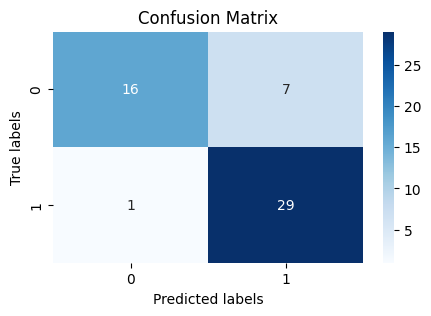

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
